In [48]:
import helpers
import math
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

## Einlesen der Tabellendaten im CSV Format
* Heizkörper, verbaut im Gebäude
* Heizköper Herstellerdaten
* Wärmepumpe Herstellerdaten
* Klimadaten des DWD

Die  [Kilmadaten](https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivtagmonat.html?nn=16102) sind dem Deutschen Wetterdienst (DWD) entnommen mit dem Filter Station=Hahn, Zeitraum=Tageswerte, Zeitliche Auflösung=historisch.

In [49]:
HK_G=helpers.read_csv("../data/hk_gebäude.csv", units={"L":"i", "H":"i", "T":"i"})
HK_D=helpers.read_csv("../data/hk_herstellerdaten.csv", units={"PHI":"f", "H":"i", "n":"f"})
# Moderne Luftwärmepumpe
WP_D=helpers.read_csv("../data/wp_herstellerdaten.csv", units={"Tu":"f", "Tv":"f", "COP":"f"})
KD_DWD=helpers.read_csv("../data/produkt_klima_tag_19981101_20221231_05871.txt", delimiter=";", units={"TMK":"f", "TNK":"f", "TXK":"f"})
PV_D=helpers.read_csv("../data/pv_jahreswerte.csv", units={"Monat":"i", "Jahr":"i", "kWh":"f"})
pass

In [50]:
# Etwas Datenaufbereitung...

#
# Maximale Heizlast ermitteln
#
hk_typ=lambda hk: f'{hk["Hersteller"]}.{hk["Serie"]}.{hk["Typ"]}.{hk["H"]}'
HKm={ hk_typ(hk) for hk in HK_G }
print(f"Heizkörpertypen im Gebäude: {HKm}")
# Heizköper Herstellerdaten indiziert über Typ
HK_D_typ={ hk_typ(hk): hk for hk in HK_D}
# Leistung PHI und n ergänzen
for hk in HK_G:
	hk["PHI"]=HK_D_typ[hk_typ(hk)]["PHI"]*hk["L"]/(1000*1000) # /mmm/1000W/kW
	hk["n"]=HK_D_typ[hk_typ(hk)]["n"]
# Heizkörper zu einem zusammenfassen und für jede Vorlauftemperaturdifferenz dT=0..55 (index) die Leistung berechnen
PHI=[ sum([ pow(hk["PHI"]*(dT/55),hk["n"]) for hk in HK_G]) for dT in range(0,55+1)]
print(f"Installierte Heizkörperleistung [kW]: {PHI[55]:.1f}")
# P=P0*(dT/55)^n => dT=55*(P/P0)^(1/n)       
# Tv=55*pow(Eh/(24)/P0, 1/n)+20+5
def dtPHI(P):
	for t in range(0, len(PHI)):		
		if PHI[t]>P:
			return t
	return 55
#
# Wärmepumpen Datenpunkte 2d-interpolieren. Linear mit nearest als Option, wenn Datenpunkt ausserhalb liegt.
#
WPa=np.array([[wp["Tu"], wp["Tv"], wp["COP"]] for wp in WP_D])
WPpoints=WPa[:,:2]
WPdata=WPa[:,2]
COPl=lambda Ta, Tv: griddata(WPpoints, WPdata, (Ta,Tv), method="linear", fill_value=np.nan)
COPn=lambda Ta, Tv: griddata(WPpoints, WPdata, (Ta,Tv), method="nearest", fill_value=np.nan)
COP=lambda Ta,Tv: COPl(Ta,Tv) if not math.isnan(COPl(Ta,Tv)) else COPn(Ta,Tv)




Heizkörpertypen im Gebäude: {'Kermi.Profil.33.600', 'Kermi.Profil.22.600', 'Kermi.Profil.12.900'}
Installierte Heizkörperleistung [kW]: 6.5


In [51]:
def per_tag(TA, F, Tu=None, debug=False):        
    TV=list()
    EP=list()
    EH=list()    
    for Ta in TA:
        Td=20-Ta
        Eh=F*Td if Td>0 else 0
        EH.append(Eh)     
        Tv=dtPHI(Eh/24)+20+5
        TV.append(Tv)
        Tu_=Ta if not Tu else Tu              
        Ep=Eh/COP(Tu_,Tv)
        EP.append(Ep)
        if debug:
            print(f"Td:{Td:1f},Em:{Eh:.1f},Tv:{Tv:.1f}, Ep:{int(Ep)}, Eh:{int(Eh)}")
    return (EP, EH, TV, TA)

# TNK: minimum, TMK: mean, TXK: maxim day temperature 
Heizperiode=lambda Jahr, Param:  [t[Param] for t in KD_DWD if t["MESS_DATUM"]>=f"{str(Jahr)}1001" and  t["MESS_DATUM"]<f"{str(Jahr+1)}0501"]
def per_saison(StartJahr, EndJahr, F):
    Jahre=list()
    EP_J=list()
    EH_J=list()
    SCOP_J=list()
    TD_J=list()
    TA_J=list()    
    for Jahr in range(StartJahr, EndJahr+1):
        TA=Heizperiode(Jahr,"TMK")
        (EP, EH, TV, TA) = per_tag(TA, F )
        Ep=sum(EP)
        Eh=sum(EH)
        Jahre.append(Jahr)
        EP_J.append(int(Ep))
        EH_J.append(int(Eh))
        SCOP_J.append(Eh/Ep)
        TA_J.append(np.mean(TA))    
    return (Jahre, EP_J, EH_J, SCOP_J, TD_J, TA_J)

Heizmonat=lambda Jahr, Monat, Param:  [t[Param] for t in KD_DWD if t["MESS_DATUM"][0:6]==f"{str(Jahr)}{Monat:02}"]
def per_monat(StartJahr, EndJahr, F):
    Jahre=list()
    EP_J=list()
    EH_J=list()
    SCOP_J=list()
    TD_J=list()
    TA_J=list()      
    for Jahr in range(StartJahr, EndJahr+1):
        EP_M=list()
        EH_M=list()
        SCOP_M=list()
        TD_M=list()
        TA_M=list()  
        for Monat in [10,11,12,1,2,3,4,5]:        
            TA=Heizmonat(Jahr if Monat>=10 else Jahr+1,Monat, "TMK")
            (EP, EH, TV, TA) = per_tag(TA, F )
            Ep=sum(EP)
            Eh=sum(EH)            
            EP_M.append(int(Ep))
            EH_M.append(int(Eh))
            SCOP_M.append(Eh/Ep)
            TA_M.append(np.mean(TA))
        EP_J.append(EP_M)
        EH_J.append(EH_M)
        SCOP_J.append(SCOP_M)
        TA_J.append(TA_M)
        Jahre.append(Jahr)
    return (Jahre, EP_J, EH_J, SCOP_J, TD_J, TA_J)


## SCOP für typischen Altbau 1970er Jahre

* Normierung auf
  * 1000 Liter Heizölverbrauch in 2020 als Referenz
  * 50qm Wohnfläche
  * Typische Heizkörperdimensionierung mit 6.5kW (etwa 125W/qm bei 75/20°C)  
* Moderne Luftwärmepumpe
* Perfekter hydraulischer Abgleich

Vereinfachte Annahmen siehe Text.

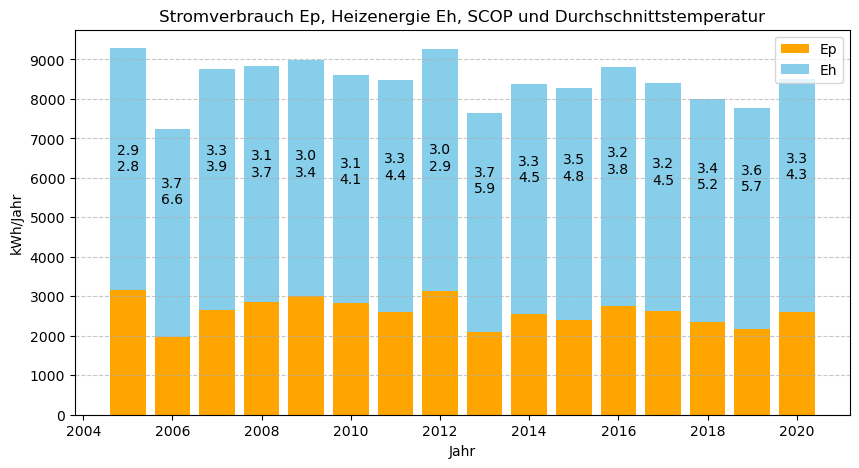

In [52]:
# Verbrauch 1000 Liter Heizöl in 2020, Normierung auf mittlere Temperatur in der Heizsaison und pro Tag
TA=Heizperiode(2020,"TMK")
F=1000*10*0.85/(20-np.mean(TA))/len(TA)

(Jahre, EP_J, EH_J, SCOP_J, TD_J, TA_J) = per_saison( 2005, 2020, F)
EPH_J=list(np.array(EH_J)-np.array(EP_J))  
#ind=np.arange(Jahr)    
fig, ax = plt.subplots(figsize = (10,5))
plt.bar(Jahre, EP_J, label='Ep', color='orange')
bars=plt.bar(Jahre, EPH_J, bottom=EP_J, label='Eh', color='skyblue')
for i,_ in enumerate(SCOP_J):
	height=bars[i].get_height()
	ax.text(bars[i].get_x() + bars[i].get_width()/2., (height*1.0), f'{SCOP_J[i]:.1f}\n{TA_J[i]:.1f}', ha='center', va='bottom', color="black")	

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.yticks([v for v in range(0,max(EH_J), 1000)])
plt.xlabel("Jahr")
plt.ylabel("kWh/Jahr")
plt.title("Stromverbrauch Ep, Heizenergie Eh, SCOP und Durchschnittstemperatur")
plt.legend()
plt.show()

# print(f"SCOP: {SCOP:.2f}")

## Stromverbrauch Ep mit hohem PV Anteil für typischen Altbau 1970er Jahre

Wie oben, aber:
* Nur Jahr 2020 betrachtet
* PV Ertragsdaten 2020 siehe [hier](https://www.umwelt-campus.de/fileadmin/Umwelt-Campus/User/HteHeesen/research/pv/Ertragsstudie_2020.pdf), perfekte Ausrichtung
* Perfekte Speicher installiert
* 10kWp installiert (was ziemlich viel ist bei 50qm/1000L Heizölverbrauch)

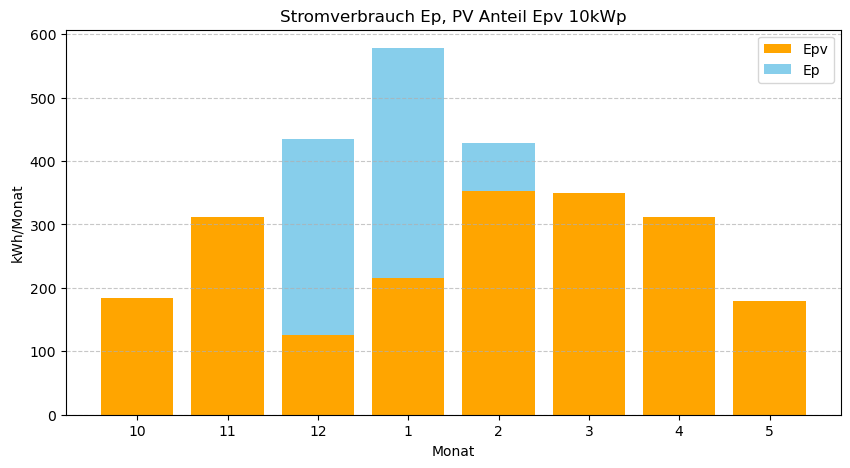

Nicht durch PV gedeckter Strombedarf [kWh]: 748


In [54]:
# Verbrauch 1000 Liter Heizöl in 2020, Normierung auf mittlere Temperatur in der Heizsaison und pro Tag
pvf=10 # Für 10kWp PV (grosse Anlage, perfekte Ausrichtung)
TA=Heizperiode(2020,"TMK")
F=1000*10*0.85/(20-np.mean(TA))/len(TA)
(Jahre, EP_J, EH_J, SCOP_J, TD_J, TA_J)=per_monat(2020,2020, F)
Monate=[10,11,12,1,2,3,4,5]
PV_M=[pvf*v["kWh"] for m in Monate for v in PV_D if v["Monat"]==m]
YPV=list()
YP=list()
for i in range(len(Monate)):
	yp=EP_J[0][i]
	ypv=PV_M[i]
	if yp>ypv:
		YPV.append(ypv)
		YP.append(yp-ypv)
	else:
		YPV.append(yp)
		YP.append(0)

fig, ax = plt.subplots(figsize = (10,5))

plt.xticks(range(len(Monate)), Monate)
plt.bar(range(len(Monate)), YPV, label='Epv', color='orange')
bars=plt.bar(range(len(Monate)), YP, bottom=YPV, label='Ep', color='skyblue')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Monat")
plt.ylabel("kWh/Monat")
plt.title("Stromverbrauch Ep, PV Anteil Epv, installiert 10kWp")
plt.legend()
plt.show()

print(f"Nicht durch PV gedeckter Strombedarf [kWh]: {int(sum(YP))}")



